# Importações

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from joblib import dump
import os

# Análise Exploratória

Classificação dos "reinos" presentes no dataset:

- 'arc'(archaea), 
- 'bct'(bacteria), 
- 'phg'(bacteriophage),
- 'plm' (plasmid), 
- 'pln' (plant), 
- 'inv' (invertebrate), 
- 'vrt' (vertebrate), 
- 'mam' (mammal), 
- 'rod' (rodent), 
- 'pri' (primate)
- 'vrl'(virus) sequence entries.

In [63]:
df = pd.read_csv('data/codon_usage.csv')

/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_64918/2497034234.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/codon_usage.csv')


In [64]:
df.shape

(13028, 69)

In [65]:
df.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [66]:
num_na = df.isnull().sum().sum()

print(f"Número total de valores ausentes: {num_na}")

Número total de valores ausentes: 0


In [31]:
number_of_species =len(df['SpeciesName'].unique())
number_of_kingdoms =len(df['Kingdom'].unique())

print(f'O dataset contém dados de {number_of_species} diferentes espécies.')
print(f'O dataset contém dados de {number_of_kingdoms} diferentes reinos.')

O dataset contém dados de 13016 diferentes espécies.
O dataset contém dados de 11 diferentes reinos.


In [32]:
df['Kingdom'].value_counts()

Kingdom
bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: count, dtype: int64

In [33]:
non_numeric_cols = df.select_dtypes(include='object').columns
print("\nColunas não numéricas:", list(non_numeric_cols))
print()
print(df[non_numeric_cols].head())


Colunas não numéricas: ['Kingdom', 'SpeciesName', 'UUU', 'UUC']

  Kingdom                              SpeciesName      UUU      UUC
0     vrl  Epizootic haematopoietic necrosis virus  0.01654  0.01203
1     vrl                         Bohle iridovirus  0.02714  0.01357
2     vrl             Sweet potato leaf curl virus  0.01974   0.0218
3     vrl             Northern cereal mosaic virus  0.01775  0.02245
4     vrl           Soil-borne cereal mosaic virus  0.02816  0.01371


## Preparação dos dados

In [67]:
df.dropna(inplace=True)

In [34]:
for col in df.columns[5:69]:
    df[col] = df[col].astype(str).str.replace(",", ".").str.replace(";", ".")
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [35]:
non_numeric_cols = df.select_dtypes(include='object').columns
print("\nColunas não numéricas:", list(non_numeric_cols))


Colunas não numéricas: ['Kingdom', 'SpeciesName']


In [36]:
kingdom_map = {
    # Grupo Vertebrata
    'vrt': 'Vertebrata',
    'mam': 'Vertebrata',
    'rod': 'Vertebrata',
    'pri': 'Vertebrata',

    # Grupo Invertebrata
    'inv': 'Invertebrata',
    
    # Grupo Plantae
    'pln': 'Plantae',
    
    # Grupo Archaea
    'arc': 'Archaea',
    
    # Grupo Bacteria
    'bct': 'Bacteria',
    'plm': 'Bacteria', # Assumindo que plasmídeos são bacterianos
    
    # Grupo Virus
    'vrl': 'Virus',
    'phg': 'Virus'
}

print("--- DataFrame Original ---")
print("\nContagem de classes original:\n", df['Kingdom'].value_counts())

df['Kingdom_group'] = df['Kingdom'].map(kingdom_map)

print("\n\n--- DataFrame Modificado ---")
print("\nContagem de classes agrupada:\n", df['Kingdom_group'].value_counts())

--- DataFrame Original ---

Contagem de classes original:
 Kingdom
bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: count, dtype: int64


--- DataFrame Modificado ---

Contagem de classes agrupada:
 Kingdom_group
Virus           3052
Vertebrata      3044
Bacteria        2938
Plantae         2523
Invertebrata    1345
Archaea          126
Name: count, dtype: int64


In [37]:
#remover linhas em que 'Kingdom_group' é Archaea
df = df[df['Kingdom_group'] != 'Archaea']

In [38]:
le = LabelEncoder()
df["Kingdom_group_encoded"] = le.fit_transform(df["Kingdom_group"])

print(dict(zip(le.classes_, le.transform(le.classes_))))
print()
print(df[['Kingdom', 'Kingdom_group', 'Kingdom_group_encoded']].head())

{'Bacteria': np.int64(0), 'Invertebrata': np.int64(1), 'Plantae': np.int64(2), 'Vertebrata': np.int64(3), 'Virus': np.int64(4)}

  Kingdom Kingdom_group  Kingdom_group_encoded
0     vrl         Virus                      4
1     vrl         Virus                      4
2     vrl         Virus                      4
3     vrl         Virus                      4
4     vrl         Virus                      4


In [39]:
X = df.iloc[:, 5:69]
y = df["Kingdom_group_encoded"]

In [40]:
X.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [42]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [43]:
print(class_weights)

{np.int64(0): np.float64(0.8783829787234042), np.int64(1): np.float64(1.9184014869888475), np.int64(2): np.float64(1.0228939544103073), np.int64(3): np.float64(0.8477207392197125), np.int64(4): np.float64(0.8452907452907453)}


In [44]:
# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

⚠️ Atenção: o scaler retorna um array NumPy, que não tem noção dos nomes das colunas originais.

In [71]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train_reset = y_train.reset_index(drop=True)
train_df_combined = pd.concat([X_train_df, y_train_reset], axis=1)

X_test_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)
y_test_reset = y_test.reset_index(drop=True)
test_df_combined = pd.concat([X_test_df, y_test_reset], axis=1)

train_df_combined.to_csv('data/train_data.csv')
test_df_combined.to_csv('data/test_data.csv')

## Otimização de hiperparâmetros

In [45]:
def objective(trial):
    # Hiperparâmetros
    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    max_depth = trial.suggest_int("max_depth", 5, 40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weights,
        random_state=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    return scores.mean()

In [46]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2025-11-09 20:31:56,507] A new study created in memory with name: no-name-4969115c-87f2-4de8-be5a-03b3ad62b34b
Best trial: 0. Best value: 0.801099:  10%|█         | 1/10 [01:26<12:58, 86.54s/it]

[I 2025-11-09 20:33:23,053] Trial 0 finished with value: 0.8010988836818547 and parameters: {'n_estimators': 216, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8010988836818547.


Best trial: 1. Best value: 0.885603:  20%|██        | 2/10 [01:50<06:36, 49.59s/it]

[I 2025-11-09 20:33:46,780] Trial 1 finished with value: 0.8856034890399492 and parameters: {'n_estimators': 617, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8856034890399492.


Best trial: 2. Best value: 0.908464:  30%|███       | 3/10 [04:55<13:00, 111.53s/it]

[I 2025-11-09 20:36:52,008] Trial 2 finished with value: 0.9084638963808696 and parameters: {'n_estimators': 460, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.9084638963808696.


Best trial: 3. Best value: 0.928925:  40%|████      | 4/10 [05:20<07:44, 77.41s/it] 

[I 2025-11-09 20:37:17,115] Trial 3 finished with value: 0.928924712673472 and parameters: {'n_estimators': 470, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.928924712673472.


Best trial: 4. Best value: 0.932073:  50%|█████     | 5/10 [05:31<04:26, 53.38s/it]

[I 2025-11-09 20:37:27,900] Trial 4 finished with value: 0.9320725434374213 and parameters: {'n_estimators': 247, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 4 with value: 0.9320725434374213.


Best trial: 4. Best value: 0.932073:  60%|██████    | 6/10 [28:11<33:10, 497.54s/it]

[I 2025-11-09 21:00:07,630] Trial 5 finished with value: 0.8044672625826987 and parameters: {'n_estimators': 759, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 4 with value: 0.9320725434374213.


Best trial: 4. Best value: 0.932073:  70%|███████   | 7/10 [31:25<19:55, 398.39s/it]

[I 2025-11-09 21:03:21,873] Trial 6 finished with value: 0.9097790013703438 and parameters: {'n_estimators': 770, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 4 with value: 0.9320725434374213.


Best trial: 4. Best value: 0.932073:  80%|████████  | 8/10 [31:41<09:13, 276.78s/it]

[I 2025-11-09 21:03:38,276] Trial 7 finished with value: 0.9136120159329815 and parameters: {'n_estimators': 482, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 4 with value: 0.9320725434374213.


Best trial: 4. Best value: 0.932073:  90%|█████████ | 9/10 [36:44<04:44, 284.74s/it]

[I 2025-11-09 21:08:40,520] Trial 8 finished with value: 0.7347526301836588 and parameters: {'n_estimators': 720, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 4 with value: 0.9320725434374213.


Best trial: 4. Best value: 0.932073: 100%|██████████| 10/10 [37:02<00:00, 222.28s/it]

[I 2025-11-09 21:08:59,287] Trial 9 finished with value: 0.9208945596482208 and parameters: {'n_estimators': 594, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 4 with value: 0.9320725434374213.


In [47]:
print("\nMelhores parâmetros encontrados:")
print(study.best_params)
print("\nMelhor F1 médio de validação cruzada:", study.best_value)


Melhores parâmetros encontrados:
{'n_estimators': 247, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}

Melhor F1 médio de validação cruzada: 0.9320725434374213


# Treinamento

In [48]:
best_params = study.best_params

rf_best = RandomForestClassifier(
    **best_params,
    class_weight=class_weights,
    random_state=42,
)

rf_best.fit(X_train_scaled, y_train)

,n_estimators,247
,criterion,'gini'
,max_depth,35
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [51]:
# cria o diretório se não existir
os.makedirs('models', exist_ok=True)

model_path = 'models/rf_best_model.joblib'

# Salva o modelo no disco
dump(rf_best, model_path)
print(f"Modelo salvo em: {model_path}")

Modelo salvo em: models/rf_best_model.joblib


# Avaliação do modelo

In [52]:
y_pred = rf_best.predict(X_test_scaled)

In [53]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Bacteria       0.94      0.97      0.95       588
Invertebrata       0.94      0.81      0.87       269
     Plantae       0.93      0.93      0.93       505
  Vertebrata       0.99      0.97      0.98       609
       Virus       0.91      0.96      0.93       610

    accuracy                           0.94      2581
   macro avg       0.94      0.93      0.93      2581
weighted avg       0.94      0.94      0.94      2581



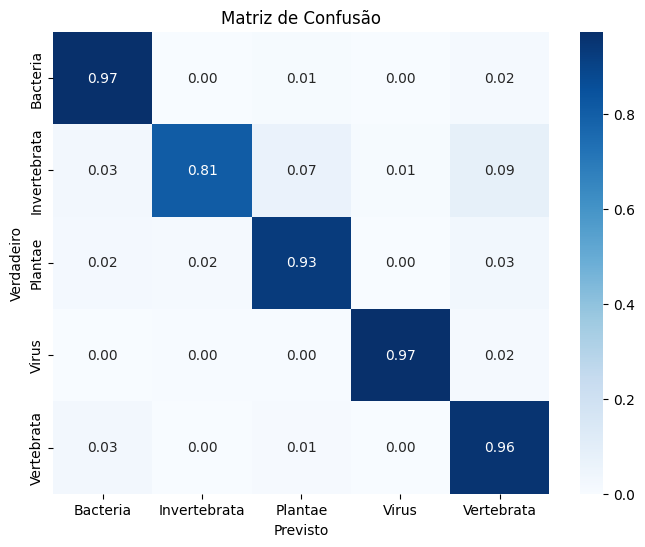

In [60]:
labels = ['Bacteria', 'Invertebrata', 'Plantae', 'Virus', 'Vertebrata']

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, 
            yticklabels=labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()